# Rational Agents

* write a variation on  a minigrid env where  the agent has to find a specific colored goal square
* write a rational agent which will find only a goal agent of a specific color

In [2]:
import itertools as itt

import numpy as np

from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Lava
from minigrid.minigrid_env import MiniGridEnv


class MazeEnv(MiniGridEnv):

    """
    ## Description
    Depending on the `obstacle_type` parameter:
    - `Lava` - The agent has to reach the green goal square on the other corner
        of the room while avoiding rivers of deadly lava which terminate the
        episode in failure. Each lava stream runs across the room either
        horizontally or vertically, and has a single crossing point which can be
        safely used; Luckily, a path to the goal is guaranteed to exist. This
        environment is useful for studying safety and safe exploration.
    - otherwise - Similar to the `LavaCrossing` environment, the agent has to
        reach the green goal square on the other corner of the room, however
        lava is replaced by walls. This MDP is therefore much easier and maybe
        useful for quickly testing your algorithms.
    ## Mission Space
    Depending on the `obstacle_type` parameter:
    - `Lava` - "avoid the lava and get to the green goal square"
    - otherwise - "find the opening and get to the green goal square"
    ## Action Space
    | Num | Name         | Action       |
    |-----|--------------|--------------|
    | 0   | left         | Turn left    |
    | 1   | right        | Turn right   |
    | 2   | forward      | Move forward |
    | 3   | pickup       | Unused       |
    | 4   | drop         | Unused       |
    | 5   | toggle       | Unused       |
    | 6   | done         | Unused       |
    ## Observation Encoding
    - Each tile is encoded as a 3 dimensional tuple:
        `(OBJECT_IDX, COLOR_IDX, STATE)`
    - `OBJECT_TO_IDX` and `COLOR_TO_IDX` mapping can be found in
        [minigrid/minigrid.py](minigrid/minigrid.py)
    - `STATE` refers to the door state with 0=open, 1=closed and 2=locked
    ## Rewards
    A reward of '1' is given for success, and '0' for failure.
    ## Termination
    The episode ends if any one of the following conditions is met:
    1. The agent reaches the goal.
    2. The agent falls into lava.
    3. Timeout (see `max_steps`).
    ## Registered Configurations
    S: size of the map SxS.
    N: number of valid crossings across lava or walls from the starting position
    to the goal
    - `Lava` :
        - `MiniGrid-LavaCrossingS9N1-v0`
        - `MiniGrid-LavaCrossingS9N2-v0`
        - `MiniGrid-LavaCrossingS9N3-v0`
        - `MiniGrid-LavaCrossingS11N5-v0`
    - otherwise :
        - `MiniGrid-SimpleCrossingS9N1-v0`
        - `MiniGrid-SimpleCrossingS9N2-v0`
        - `MiniGrid-SimpleCrossingS9N3-v0`
        - `MiniGrid-SimpleCrossingS11N5-v0`
    """

    def __init__(
        self,
        size=9,
        obstacle_type=Lava,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.obstacle_type = obstacle_type

        if obstacle_type == Lava:
            mission_space = MissionSpace(mission_func=self._gen_mission_lava)
        else:
            mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=False,  # Set this to True for maximum speed
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission_lava():
        return "avoid the lava and get to the green goal square"

    @staticmethod
    def _gen_mission():
        return "find the opening and get to the green goal square"

    def _gen_grid(self, width, height):
        assert width % 2 == 1 and height % 2 == 1  # odd size

        # Create an empty grid
        self.grid = Grid(width, height)

        # cell obj
        cell = object()

        starting_height = max(1,int(self.np_random.random()*(height-1)))
        starting_width = max(1,int(self.np_random.random()*(width-1)))

        self.grid.set(starting_height, starting_width, cell)

        walls = []
        for i,j in ([-1,0],[0,-1],[0,1],[1,0]):
            walls.append([starting_height+i,starting_width+j])
            self.put_obj(self.obstacle_type(), starting_height+i, starting_width+j)

        # Find number of surrounding cells
        def surroundingCells(rand_wall):
            s_cells = 0
            for i,j in ([-1,0],[0,-1],[0,1],[1,0]):
                if (self.grid.get(rand_wall[0]+i,rand_wall[1]+j) == cell):
                    s_cells += 1
            return s_cells

        def delete_wall(walls, rand_wall):
            for wall in walls:
                if (wall[0] == rand_wall[0] and wall[1] == rand_wall[1]):
                    walls.remove(wall)

        while walls:
                # Pick a random wall
                rand_wall = walls[int(self.np_random.random()*len(walls))-1]

                # Check if it is a left wall
                if (rand_wall[1] != 0):

                    if (self.grid.get(rand_wall[0],rand_wall[1]-1) == None and self.grid.get(rand_wall[0],rand_wall[1]+1) == cell):
                        # Find the number of surrounding cells
                        s_cells = surroundingCells(rand_wall)
                        if (s_cells < 2):
                            # Denote the new path
                            self.grid.set(rand_wall[0], rand_wall[1], cell)

                            # Mark the new walls
                            # Upper cell
                            if (rand_wall[0] != 0):
                                if (self.grid.get(rand_wall[0]-1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]-1, rand_wall[1])
                                if ([rand_wall[0]-1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]-1, rand_wall[1]])


                            # Bottom cell
                            if (rand_wall[0] != height-1):
                                if (self.grid.get(rand_wall[0]+1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]+1, rand_wall[1])
                                if ([rand_wall[0]+1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]+1, rand_wall[1]])

                            # Leftmost cell
                            if (rand_wall[1] != 0):	
                                if (self.grid.get(rand_wall[0],rand_wall[1]-1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]-1)
                                if ([rand_wall[0], rand_wall[1]-1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]-1])


                        # Delete wall
                        delete_wall(walls, rand_wall)

                        continue

                # Check if it is an upper wall
                if (rand_wall[0] != 0):
                    if (self.grid.get(rand_wall[0]-1,rand_wall[1]) == None and self.grid.get(rand_wall[0]+1,rand_wall[1]) == cell):

                        s_cells = surroundingCells(rand_wall)
                        if (s_cells < 2):
                            # Denote the new path
                            self.grid.set(rand_wall[0], rand_wall[1], cell)

                            # Mark the new walls
                            # Upper cell
                            if (rand_wall[0] != 0):
                                if (self.grid.get(rand_wall[0]-1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]-1, rand_wall[1])
                                if ([rand_wall[0]-1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]-1, rand_wall[1]])

                            # Leftmost cell
                            if (rand_wall[1] != 0):
                                if (self.grid.get(rand_wall[0],rand_wall[1]-1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]-1)
                                if ([rand_wall[0], rand_wall[1]-1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]-1])

                            # Rightmost cell
                            if (rand_wall[1] != width-1):
                                if (self.grid.get(rand_wall[0],rand_wall[1]+1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]+1)
                                if ([rand_wall[0], rand_wall[1]+1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]+1])

                        # Delete wall
                        delete_wall(walls, rand_wall)

                        continue


                # Check the bottom wall
                if (rand_wall[0] != height-1):
                    if (self.grid.get(rand_wall[0]+1,rand_wall[1]) == None and self.grid.get(rand_wall[0]-1,rand_wall[1]) == cell):

                        s_cells = surroundingCells(rand_wall)
                        if (s_cells < 2):
                            # Denote the new path
                            self.grid.set(rand_wall[0], rand_wall[1], cell)

                            # Mark the new walls
                            if (rand_wall[0] != height-1):
                                if (self.grid.get(rand_wall[0]+1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]+1, rand_wall[1])
                                if ([rand_wall[0]+1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]+1, rand_wall[1]])
                            if (rand_wall[1] != 0):
                                if (self.grid.get(rand_wall[0],rand_wall[1]-1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]-1)
                                if ([rand_wall[0], rand_wall[1]-1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]-1])
                            if (rand_wall[1] != width-1):
                                if (self.grid.get(rand_wall[0],rand_wall[1]+1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]+1)
                                if ([rand_wall[0], rand_wall[1]+1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]+1])

                        # Delete wall
                        delete_wall(walls, rand_wall)


                        continue

                # Check the right wall
                if (rand_wall[1] != width-1):
                    if (self.grid.get(rand_wall[0],rand_wall[1]+1) == None and self.grid.get(rand_wall[0],rand_wall[1]-1) == cell):

                        s_cells = surroundingCells(rand_wall)
                        if (s_cells < 2):
                            # Denote the new path
                            self.grid.set(rand_wall[0], rand_wall[1], cell)

                            # Mark the new walls
                            if (rand_wall[1] != width-1):
                                if (self.grid.get(rand_wall[0],rand_wall[1]+1) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0], rand_wall[1]+1)
                                if ([rand_wall[0], rand_wall[1]+1] not in walls):
                                    walls.append([rand_wall[0], rand_wall[1]+1])
                            if (rand_wall[0] != height-1):
                                if (self.grid.get(rand_wall[0]+1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]+1, rand_wall[1])
                                if ([rand_wall[0]+1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]+1, rand_wall[1]])
                            if (rand_wall[0] != 0):	
                                if (self.grid.get(rand_wall[0]-1,rand_wall[1]) != cell):
                                    self.put_obj(self.obstacle_type(), rand_wall[0]-1, rand_wall[1])
                                if ([rand_wall[0]-1, rand_wall[1]] not in walls):
                                    walls.append([rand_wall[0]-1, rand_wall[1]])

                        # Delete wall
                        delete_wall(walls, rand_wall)

                        continue

                # Delete the wall from the list anyway
                delete_wall(walls, rand_wall)

        # Set entrance and exit
        cells = []
        for i in range(0, width):
            if (self.grid.get(1,i) == cell):
                cells.append((1,i))

        self.agent_pos = np.array(self.np_random.choice(cells))
        self.agent_dir = 0

        cells = []
        for i in range(width-1, 0, -1):
            if (self.grid.get(height-2,i) == cell):
                cells.append((height-2, i))

        pt = self.np_random.choice(cells)
        self.put_obj(Goal(), pt[0], pt[1])

        # Mark the remaining unvisited cells as walls
        for i in range(0, height):
            for j in range(0, width):
                if (self.grid.get(i,j) == None):
                    self.put_obj(self.obstacle_type(), i, j)
                if (self.grid.get(i,j) == cell):
                    self.grid.set(i, j, None)

        self.mission = (
            "avoid the lava and get to the green goal square"
            if self.obstacle_type == Lava
            else "find the opening and get to the green goal square"
        )

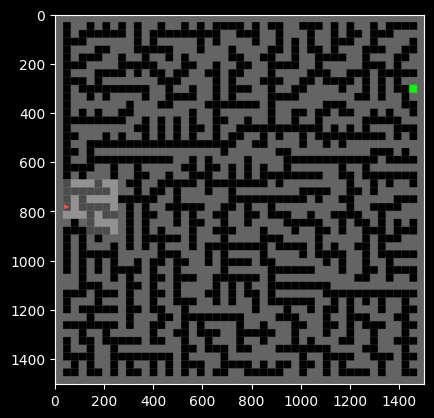

In [4]:
from minigrid.core.world_object import Wall, Goal, Lava
from minigrid.wrappers import FullyObsWrapper
env = MazeEnv(
    size = 47,
    obstacle_type=Wall,
    max_steps=2000,
    render_mode="rgb_array"
)
env = FullyObsWrapper(env)
obs, info = env.reset()

import matplotlib.pyplot as plt
plt.imshow(env.render())

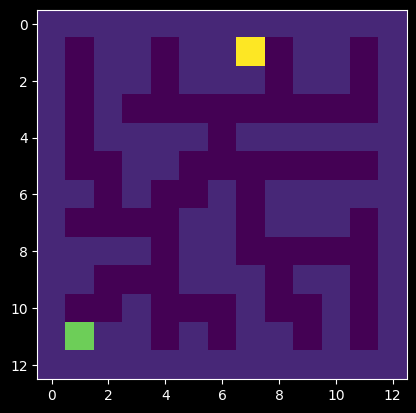

In [4]:
state = obs['image'][:,:,0]

plt.imshow(state)


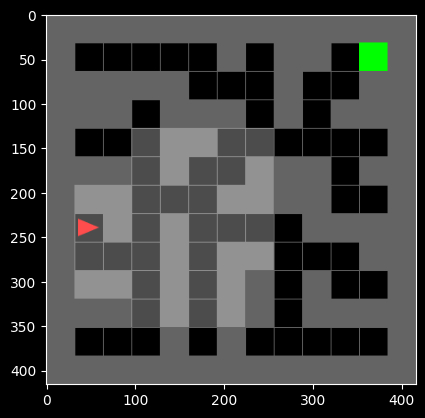

In [5]:
from copy import deepcopy
env_copy = deepcopy(env)
env.step(2)
plt.imshow(env.render())

In [60]:
from minigrid.core.constants import DIR_TO_VEC

class WallFollowingAgent:
    def __init__(self, env):
        self.env = env
        self.visited = set()  # set to keep track of visited cells
        self.path = []  # list to keep track of the path taken
        self.current_pos = None  # current position of the agent
        self.current_dir = None  # current direction of the agent
        self.last_action = None  # last action taken by the agent

    def reset(self):
        self.visited = set()
        self.path = []
        self.current_pos = None
        self.current_dir = None
        self.last_action = None

    def get_next_action(self, obs):
        # convert observation to a grid
        
        wall_on_left = self.wall_on_left_of_agent(obs)
        wall_in_front = self.wall_in_front_of_agent(obs)
        # if agent i

        print(wall_on_left, wall_in_front)

        if wall_in_front:
            return 0
        elif wall_on_left and not wall_in_front:
            return 2
        else:
            return 0

    def wall_on_left_of_agent(self, obs):

        position_left_of_agent = self.get_left_of_agent()
        # print(position_left_of_agent)
        wall_on_left = obs['image'][position_left_of_agent[0],position_left_of_agent[1],0] == 2
        return wall_on_left

    def wall_in_front_of_agent(self, obs):
            
        position_in_front_of_agent = self.get_front_of_agent()
        wall_in_front = obs['image'][position_in_front_of_agent[0],position_in_front_of_agent[1],0] == 2
        return wall_in_front
    
    def get_front_of_agent(self):

        agent_pos = self.env.agent_pos
        agent_dir = self.env.agent_dir

        dir_vec = DIR_TO_VEC[agent_dir]
        return (agent_pos[0] + dir_vec[0], agent_pos[1] + dir_vec[1])
    
    def get_left_of_agent(self):

        agent_pos = self.env.agent_pos
        agent_dir = self.env.agent_dir

        dir_vec = DIR_TO_VEC[agent_dir]
        return (agent_pos[0] - dir_vec[1], agent_pos[1] + dir_vec[0])
    


env = MazeEnv(
    size = 13,
    obstacle_type=Wall,
    max_steps=2000,
    render_mode="rgb_array"
)

# open window
env = FullyObsWrapper(env)
obs, info = env.reset()
# env.render()

agent = WallFollowingAgent(env)


images=[]
obss = []
counter = 0 
done = False
while not done:
    # print("ll")
    action = agent.get_next_action(obs)
    # print(action)
    obs, reward, done, trunc, info = env.step(action)
    images.append(env.render())
    obss.append(obs['image'][:,:,0].T)
    counter += 1

    if counter > 100:
        break
    
import plotly.express as px 
fig = px.imshow(np.stack(images), animation_frame=0, binary_string=True)
fig.show()


False True
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True True
True False
True False
True False
True True
True True
True False
True False
True False
False True
True